In [117]:
import numpy as np
from scipy import stats

class Random_Variable:

    def __init__(self, name, values, probability_distribution):
        self.name = name
        self.values = values
        self.probability_distribution = probability_distribution
        if all(type(item) is np.int64 for item in values):
            self.type = 'numeric'
            self.rv = stats.rv_discrete(name = name, values = (values, probability_distribution))
        elif all(type(item) is str for item in values):
            self.type = 'symbolic'
            self.rv = stats.rv_discrete(name = name, values = (np.arange(len(values)), probability_distribution))
            self.symbolic_values = values
        else:
            self.type = 'undefined'

    def sample(self,size):
        if (self.type =='numeric'):
            return self.rv.rvs(size=size)
        elif (self.type == 'symbolic'):
            numeric_samples = self.rv.rvs(size=size)
            mapped_samples = [self.values[x] for x in numeric_samples]
            return mapped_samples

    def get_name(self):
        return self.name

def dice_war(A, B, num_samples=1000, output=True):
    """
    Simulates a dice war between two random variables and calculates the probability of one beating the other.

    Parameters
    ----------
    A : Random_Variable
        The first random variable (dice A).
    B : Random_Variable
        The second random variable (dice B).
    num_samples : int, optional
        The number of samples to generate for the simulation (default is 1000).
    output : bool, optional
        A flag to print the result to the console (default is True).

    Returns
    -------
    tuple
        A tuple containing a boolean indicating whether A beats B and the probability of A beating B.
    """
    samples_A = A.sample(num_samples)
    samples_B = B.sample(num_samples)

    # Count the number of times A wins
    count_A_wins = np.sum(samples_A > samples_B)

    # Calculate the probability of A beating B
    prob_A_beats_B = count_A_wins / num_samples

    if output:
        if prob_A_beats_B > 0.5:
            print('{} beats {} with probability {:.2f}'.format(A.get_name(), B.get_name(), prob_A_beats_B))
        else:
            print('{} beats {} with probability {:.2f}'.format(B.get_name(), A.get_name(), 1.0 - prob_A_beats_B))

    return prob_A_beats_B > 0.5, prob_A_beats_B


# Example usage:
values = np.array([1, 2, 3, 4, 5, 6])
probabilities_A = np.array([1 / 6., 1 / 6., 1 / 6., 1 / 6., 1 / 6., 1 / 6.])
probabilities_B = np.array([0.0, 0.0, 0 / 6., 3 / 6., 3 / 6., 0 / 6.])

dieA = Random_Variable('DieA', values, probabilities_A)
dieB = Random_Variable('DieB', values, probabilities_B)

# Test dice_war function
result, prob = dice_war(dieA, dieB)

values_red = np.array([2, 2, 4, 4, 9, 9])
values_green = np.array([1, 1, 6, 6, 8, 8])
values_blue = np.array([3, 3, 5, 5, 7, 7])

probabilities_red = np.array([1 / 6., 1 / 6., 1 / 6., 1 / 6., 1 / 6., 1 / 6.])
probabilities_green = np.array([1 / 6., 1 / 6., 1 / 6., 1 / 6., 1 / 6., 1 / 6.])
probabilities_blue = np.array([1 / 6., 1 / 6., 1 / 6., 1 / 6., 1 / 6., 1 / 6.])

red_die = Random_Variable('Red', values_red, probabilities_red)
green_die = Random_Variable('Green', values_green, probabilities_green)
blue_die = Random_Variable('Blue', values_blue, probabilities_blue)

# Red beats Green, Green beats Blue, Blue beats Red
result_red_green, prob_red_green = dice_war(red_die, green_die)
result_green_blue, prob_green_blue = dice_war(green_die, blue_die)
result_blue_red, prob_blue_red = dice_war(blue_die, red_die)



DieB beats DieA with probability 0.75
Red beats Green with probability 0.58
Green beats Blue with probability 0.54
Blue beats Red with probability 0.53


In [118]:
import numpy as np
import random

def extend(s, var, val):
    """Copy dict s and extend it by setting var to val; return copy."""
    return {**s, var: val}

def event_values(event, variables):
    """Return a tuple of the values of variables in event.
    >>> event_values ({'A': 10, 'B': 9, 'C': 8}, ['C', 'A'])
    (8, 10)
    >>> event_values ((1, 2), ['C', 'A'])
    (1, 2)
    """
    if isinstance(event, tuple) and len(event) == len(variables):
        return event
    else:
        return tuple([event[var] for var in variables])

def probability(p):
    """Return true with probability p."""
    return p > random.uniform(0.0, 1.0)

class ProbDist:
    """A discrete probability distribution. You name the random variable
    in the constructor, then assign and query probability of values.
    >>> P = ProbDist('Flip'); P['H'], P['T'] = 0.25, 0.75; P['H']
    0.25
    >>> P = ProbDist('X', {'lo': 125, 'med': 375, 'hi': 500})
    >>> P['lo'], P['med'], P['hi']
    (0.125, 0.375, 0.5)
    """

    def __init__(self, var_name='?', freq=None):
        """If freq is given, it is a dictionary of values - frequency pairs,
        then ProbDist is normalized."""
        self.prob = {}
        self.var_name = var_name
        self.values = []
        if freq:
            for (v, p) in freq.items():
                self[v] = p
            self.normalize()

    def __getitem__(self, val):
        """Given a value, return P(value)."""
        try:
            return self.prob[val]
        except KeyError:
            return 0

    def __setitem__(self, val, p):
        """Set P(val) = p."""
        if val not in self.values:
            self.values.append(val)
        self.prob[val] = p

    def normalize(self):
        """Make sure the probabilities of all values sum to 1.
        Returns the normalized distribution.
        Raises a ZeroDivisionError if the sum of the values is 0."""
        total = sum(self.prob.values())
        if not np.isclose(total, 1.0):
            for val in self.prob:
                self.prob[val] /= total
        return self

    def show_approx(self, numfmt='{:.3g}'):
        """Show the probabilities rounded and sorted by key, for the
        sake of portable doctests."""
        return ', '.join([('{}: ' + numfmt).format(v, p) for (v, p) in sorted(self.prob.items())])

    def __repr__(self):
        return "P({})".format(self.var_name)


class BayesNode:
    """A conditional probability distribution for a boolean variable,
    P(X | parents). Part of a BayesNet."""

    def __init__(self, X, parents, cpt):
        """X is a variable name, and parents a sequence of variable
        names or a space-separated string. cpt, the conditional
        probability table, takes one of these forms:

        * A number, the unconditional probability P(X=true). You can
          use this form when there are no parents.

        * A dict {v: p, ...}, the conditional probability distribution
          P(X=true | parent=v) = p. When there's just one parent.

        * A dict {(v1, v2, ...): p, ...}, the distribution P(X=true |
          parent1=v1, parent2=v2, ...) = p. Each key must have as many
          values as there are parents. You can use this form always;
          the first two are just conveniences.

        In all cases the probability of X being false is left implicit,
        since it follows from P(X=true).

        >>> X = BayesNode('X', '', 0.2)
        >>> Y = BayesNode('Y', 'P', {T: 0.2, F: 0.7})
        >>> Z = BayesNode('Z', 'P Q',
        ...    {(T, T): 0.2, (T, F): 0.3, (F, T): 0.5, (F, F): 0.7})
        """
        if isinstance(parents, str):
            parents = parents.split()

        # We store the table always in the third form above.
        if isinstance(cpt, (float, int)):  # no parents, 0-tuple
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # one parent, 1-tuple
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v,): p for v, p in cpt.items()}

        assert isinstance(cpt, dict)
        for vs, p in cpt.items():
            assert isinstance(vs, tuple) and len(vs) == len(parents)
            assert all(isinstance(v, bool) for v in vs)
            assert 0 <= p <= 1

        self.variable = X
        self.parents = parents
        self.cpt = cpt
        self.children = []

    def p(self, value, event):
        """Return the conditional probability
        P(X=value | parents=parent_values), where parent_values
        are the values of parents in event. (event must assign each
        parent a value.)
        >>> bn = BayesNode('X', 'Burglary', {T: 0.2, F: 0.625})
        >>> bn.p(False, {'Burglary': False, 'Earthquake': True})
        0.375"""
        assert isinstance(value, bool)
        ptrue = self.cpt[event_values(event, self.parents)]
        return ptrue if value else 1 - ptrue

    def sample(self, event):
        """Sample from the distribution for this variable conditioned
        on event's values for parent_variables. That is, return True/False
        at random according with the conditional probability given the
        parents."""
        return probability(self.p(True, event))

    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))


class BayesNet:
    """Bayesian network containing only boolean-variable nodes."""

    def __init__(self, node_specs=None):
        """Nodes must be ordered with parents before children."""
        self.nodes = []
        self.variables = []
        node_specs = node_specs or []
        for node_spec in node_specs:
            self.add(node_spec)

    def add(self, node_spec):
        """Add a node to the net. Its parents must already be in the
        net, and its variable must not."""
        node = BayesNode(*node_spec)
        assert node.variable not in self.variables
        # assert all((parent in self.variables) for parent in node.parents)
        self.nodes.append(node)
        self.variables.append(node.variable)
        for parent in node.parents:
            # self.variable_node(parent).children.append(node)
            pass

    def variable_node(self, var):
        """Return the node for the variable named var.
        >>> burglary.variable_node('Burglary').variable
        'Burglary'"""

        for n in self.nodes:
            if n.variable == var:
                return n
        raise Exception("No such variable: {}".format(var))

    def variable_values(self, var):
        """Return the domain of var."""
        return [True, False]

    def __repr__(self):
        return 'BayesNet({0!r})'.format(self.nodes)


def enumerate_all(variables, e, bn):
    """Return the sum of those entries in P(variables | e{others})
    consistent with e, where P is the joint distribution represented
    by bn, and e{others} means e restricted to bn's other variables
    (the ones other than variables). Parents must precede children in variables."""
    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    Ynode = bn.variable_node(Y)
    if Y in e:
        return Ynode.p(e[Y], e) * enumerate_all(rest, e, bn)
    else:
        return sum(Ynode.p(y, e) * enumerate_all(rest, extend(e, Y, y), bn)
                   for y in bn.variable_values(Y))

def enumeration_ask(X, e, bn):
    """
    [Figure 14.9]
    Return the conditional probability distribution of variable X
    given evidence e, from BayesNet bn.
    >>> enumeration_ask('Burglary', dict(JohnCalls=T, MaryCalls=T), burglary
    ...  ).show_approx()
    'False: 0.716, True: 0.284'"""
    assert X not in e, "Query variable must be distinct from evidence"
    Q = ProbDist(X)
    for xi in bn.variable_values(X):
        Q[xi] = enumerate_all(bn.variables, extend(e, X, xi), bn)
    return Q.normalize()

def consistent_with(event, evidence):
    """Is event consistent with the given evidence?"""
    return all(evidence.get(k, v) == v for k, v in event.items())

def prior_sample(bn):
    """
    [Figure 14.13]
    Randomly sample from bn's full joint distribution.
    The result is a {variable: value} dict.
    """
    event = {}
    for node in bn.nodes:
        event[node.variable] = node.sample(event)
    return event

def rejection_sampling(X, e, bn, N=10000):
    """
    [Figure 14.14]
    Estimate the probability distribution of variable X given
    evidence e in BayesNet bn, using N samples.
    Raises a ZeroDivisionError if all the N samples are rejected,
    i.e., inconsistent with e.
    >>> random.seed(47)
    >>> rejection_sampling('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.7, True: 0.3'
    """
    counts = {x: 0 for x in bn.variable_values(X)}  # bold N in [Figure 14.14]
    for j in range(N):
        sample = prior_sample(bn)  # boldface x in [Figure 14.14]
        if consistent_with(sample, e):
            counts[sample[X]] += 1
    return ProbDist(X, counts)

def weighted_sample(bn, e):
    """
    Sample an event from bn that's consistent with the evidence e;
    return the event and its weight, the likelihood that the event
    accords to the evidence.
    """
    w = 1
    event = dict(e)  # boldface x in [Figure 14.15]
    for node in bn.nodes:
        Xi = node.variable
        if Xi in e:
            w *= node.p(e[Xi], event)
        else:
            event[Xi] = node.sample(event)
    return event, w

def likelihood_weighting(X, e, bn, N=10000):
    """
    [Figure 14.15]
    Estimate the probability distribution of variable X given
    evidence e in BayesNet bn.
    >>> random.seed(1017)
    >>> likelihood_weighting('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.702, True: 0.298'
    """
    W = {x: 0 for x in bn.variable_values(X)}
    for j in range(N):
        sample, weight = weighted_sample(bn, e)  # boldface x, w in [Figure 14.15]
        W[sample[X]] += weight
    return ProbDist(X, W)

from collections import Counter
bn = BayesNode('X', 'Burglary', {True: 0.2, False: 0.625})

bn.p(True, {'Burglary': False, 'Earthquake': True})

samples = []
for i in range(0,10000):
    samples.append(bn.sample({'Burglary': True, 'Earthquake': True}))
print(Counter(samples))
burglary = BayesNet([
        ('Burglary', '', 0.001),
        ('Earthquake', '', 0.002),
        ('Alarm', ['Burglary', 'Earthquake'],
         {(True, True): 0.95, (True, False): 0.94, (False, True): 0.29, (False, False): 0.001}),
        ('JohnCalls', 'Alarm', {True: 0.90, False: 0.05}),
        ('MaryCalls', 'Alarm', {True: 0.70, False: 0.01})
    ])
print(burglary.variable_node('Alarm').cpt)
ans_dist = enumeration_ask('Burglary', {'JohnCalls': True, 'MaryCalls': True}, burglary)
print(ans_dist[True],ans_dist[False])
print(rejection_sampling('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary, 10000).show_approx())
dispnea = BayesNet([
    ('PositiveXRay', '', 0.05),
    ('PositiveCTScan', '', 0.02),
    ('LungCancer', 'PositiveXRay PositiveCTScan', {(True, True): 0.99, (True, False): 0.90, (False, True): 0.90, (False, False): 0.01}),
    ('VisitToDoctor', 'LungCancer Smoking', {(True, True): 0.90, (True, False): 0.70, (False, True): 0.05, (False, False): 0.01}),
    ('Smoking', '', 0.20)
])

# Display the CPT for the Lung Cancer Node
print(dispnea.variable_node('LungCancer').cpt)


Counter({False: 8069, True: 1931})
{(True, True): 0.95, (True, False): 0.94, (False, True): 0.29, (False, False): 0.001}
0.2841718353643929 0.7158281646356071
False: 0.56, True: 0.44
{(True, True): 0.99, (True, False): 0.9, (False, True): 0.9, (False, False): 0.01}


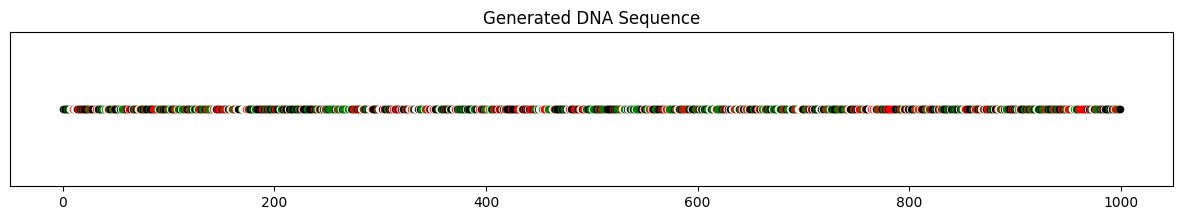

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Define the HMM model parameters
n_components = 2  # Number of hidden states (CGD and CGS)
nucleobases = ['A', 'C', 'G', 'T']
state_colors = ['black', 'white']  # Hidden state colors

# Transition probabilities
transition_matrix = np.array([[0.63, 0.37], [0.37, 0.63]])

# Initial state probabilities
initial_state_probs = np.array([0.5, 0.5])

# Observation probabilities
observation_probs = np.array([[0.15, 0.35, 0.35, 0.15],
                              [0.40, 0.10, 0.10, 0.40]])

# Generate a sequence of 1000 samples
n_samples = 1000
samples = np.zeros(n_samples, dtype=int)
hidden_states = np.zeros(n_samples, dtype=int)

# Initialize the first hidden state
hidden_states[0] = np.random.choice(n_components, p=initial_state_probs)

# Generate the sequence
for i in range(1, n_samples):
    hidden_states[i] = np.random.choice(n_components, p=transition_matrix[hidden_states[i - 1]])
    samples[i] = np.random.choice(len(nucleobases), p=observation_probs[hidden_states[i]])

# Map observations to colors
color_mapping = {0: 'black', 1: 'white', 2: 'red', 3: 'green', 4: 'blue', 5: 'yellow'}  # Colors for A, C, T, G

# Visualize the sequence
fig, ax = plt.subplots(figsize=(15, 2))
for i in range(n_samples):
    ax.scatter(i, 0, color=color_mapping[samples[i]], s=20)

ax.set_yticks([])
ax.set_title('Generated DNA Sequence')
plt.show()


In [120]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

# Set random seed for reproducibility
np.random.seed(42)

# Define the original HMM model parameters
n_components = 2  # Number of hidden states (CGD and CGS)
model = hmm.MultinomialHMM(n_components=n_components)

# Transition probabilities
model.transmat_ = np.array([[0.63, 0.37], [0.37, 0.63]])

# Initial state probabilities
model.startprob_ = np.array([0.5, 0.5])

# Observation probabilities
model.emissionprob_ = np.array([[0.15, 0.35, 0.35, 0.15],
                                [0.40, 0.10, 0.10, 0.40]])

# Generate 10,000 samples using the original HMM
n_samples = 10000
samples, _ = model.sample(n_samples)  # Discard hidden states

# Learn the HMM from the generated samples
estimated_model = hmm.MultinomialHMM(n_components=n_components)
estimated_model.fit(samples.reshape(-1, 1))  # Reshape samples for fitting

# Display the original and estimated HMM parameters
print("Original Transition Matrix:")
print(model.transmat_)
print("\nOriginal Observation Matrix:")
print(model.emissionprob_)

print("\nEstimated Transition Matrix:")
print(estimated_model.transmat_)
print("\nEstimated Observation Matrix:")
print(estimated_model.emissionprob_)


Original Transition Matrix:
[[0.63 0.37]
 [0.37 0.63]]

Original Observation Matrix:
[[0.15 0.35 0.35 0.15]
 [0.4  0.1  0.1  0.4 ]]

Estimated Transition Matrix:
[[0.60034388 0.39965612]
 [0.46212011 0.53787989]]

Estimated Observation Matrix:
[[0.33934018 0.08948332 0.12044161 0.45073489]
 [0.19886079 0.38302852 0.34485085 0.07325983]]


In [121]:
import tarfile
import os
from collections import defaultdict
import re
from google.colab import drive
#uploaded = files.upload()
drive.mount('/content/gdrive/')

# Specify the path to the tar.gz file within Google Drive
tar_file_path = '/content/gdrive/MyDrive/review_polarity.tar.gz'

# Function to extract the dataset
def extract_dataset():
    with tarfile.open(tar_file_path, "r:gz") as tar:
        tar.extractall()

# Extract the dataset
extract_dataset()
# Function to preprocess text and extract words
def preprocess_text(text):
    # Convert to lowercase and remove non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    return text.split()

# Function to build the Naive Bayes classifier
def train_naive_bayes(data_path):
    # Initialize dictionaries to store word counts for positive and negative reviews
    pos_word_counts = defaultdict(int)
    neg_word_counts = defaultdict(int)
    pos_total_words = 0
    neg_total_words = 0

    # Iterate through positive and negative folders
    for polarity in ["pos", "neg"]:
        folder_path = os.path.join(data_path, polarity)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                text = file.read()
                words = preprocess_text(text)

                # Update word counts based on polarity
                if polarity == "pos":
                    for word in words:
                        pos_word_counts[word] += 1
                        pos_total_words += 1
                else:
                    for word in words:
                        neg_word_counts[word] += 1
                        neg_total_words += 1

    # Calculate probabilities
    pos_probs = {word: count / pos_total_words for word, count in pos_word_counts.items()}
    neg_probs = {word: count / neg_total_words for word, count in neg_word_counts.items()}

    return pos_probs, neg_probs

# Train the Naive Bayes classifier
data_path = "txt_sentoken"
pos_probs, neg_probs = train_naive_bayes(data_path)

# Display probabilities for a few words
print("Positive Probabilities:")
for word, prob in list(pos_probs.items())[:5]:
    print(f"{word}: {prob:.4f}")

print("\nNegative Probabilities:")
for word, prob in list(neg_probs.items())[:5]:
    print(f"{word}: {prob:.4f}")


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Positive Probabilities:
susan: 0.0000
grangers: 0.0000
review: 0.0002
of: 0.0272
legally: 0.0000

Negative Probabilities:
synopsis: 0.0001
nice: 0.0003
girl: 0.0004
susanne: 0.0000
has: 0.0035


In [122]:
import numpy as np

class BernoulliNaiveBayes:
    def __init__(self, dictionary, prior_pos, prior_neg, cond_probs_pos, cond_probs_neg):
        self.dictionary = dictionary
        self.prior_pos = prior_pos
        self.prior_neg = prior_neg
        self.cond_probs_pos = cond_probs_pos
        self.cond_probs_neg = cond_probs_neg

    def predict(self, text):
        # Convert the text to a binary vector representation
        binary_vector = np.zeros(len(self.dictionary), dtype=int)
        words = text.split()
        for i, word in enumerate(self.dictionary):
            if word in words:
                binary_vector[i] = 1

        # Calculate the log-likelihoods for positive and negative classes
        log_likelihood_pos = np.sum(np.log(self.cond_probs_pos[binary_vector == 1])) + \
                             np.sum(np.log(1 - self.cond_probs_pos[binary_vector == 0]))
        log_likelihood_neg = np.sum(np.log(self.cond_probs_neg[binary_vector == 1])) + \
                             np.sum(np.log(1 - self.cond_probs_neg[binary_vector == 0]))

        # Calculate the log-posteriors
        log_posterior_pos = np.log(self.prior_pos) + log_likelihood_pos
        log_posterior_neg = np.log(self.prior_neg) + log_likelihood_neg

        # Make a prediction
        if log_posterior_pos > log_posterior_neg:
            return "Positive"
        else:
            return "Negative"

# Example usage:
# Assume you have already calculated the required probabilities and dictionary
dictionary = ["Awful", "Bad", "Boring", "Dull", "Effective", "Enjoyable", "Great", "Hilarious"]
prior_pos = 0.5
prior_neg = 0.5
cond_probs_pos = np.array([0.1, 0.2, 0.01, 0.05, 0.8, 0.6, 0.9, 0.7])
cond_probs_neg = np.array([0.9, 0.8, 0.99, 0.95, 0.2, 0.4, 0.1, 0.3])

# Create the classifier
classifier = BernoulliNaiveBayes(dictionary, prior_pos, prior_neg, cond_probs_pos, cond_probs_neg)

# Test the classifier with some examples
test_review1 = "The movie was effective and enjoyable."
test_review2 = "The film was awful and boring."

prediction1 = classifier.predict(test_review1)
prediction2 = classifier.predict(test_review2)

print(f"Prediction for Review 1: {prediction1}")
print(f"Prediction for Review 2: {prediction2}")


Prediction for Review 1: Positive
Prediction for Review 2: Positive


In [123]:
import numpy as np

class BernoulliNaiveBayes:
    def __init__(self, dictionary, prior_pos, prior_neg, cond_probs_pos, cond_probs_neg):
        self.dictionary = dictionary
        self.prior_pos = prior_pos
        self.prior_neg = prior_neg
        self.cond_probs_pos = cond_probs_pos
        self.cond_probs_neg = cond_probs_neg

    def predict(self, text):

      positive_reviews = ["Effective and enjoyable film.", "Great movie.", "Awful and boring.", "Enjoyable experience."]
negative_reviews = ["Terrible movie.", "Waste of time.", "Hated it.", "Boring and dull."]
positive_labels = [1, 1, 0, 1]  # 1 for positive, 0 for negative
negative_labels = [0, 0, 0, 0]
# ... (same as the previous code)

# Generate some example data
# Let's assume you have two sets of reviews and labels: positive_reviews, negative_reviews, positive_labels, negative_labels
positive_reviews = ["Effective and enjoyable film.", "Great movie.", "Awful and boring.", "Enjoyable experience."]
negative_reviews = ["Terrible movie.", "Waste of time.", "Hated it.", "Boring and dull."]
positive_labels = [1, 1, 0, 1]  # 1 for positive, 0 for negative
negative_labels = [0, 0, 0, 0]

# Combine positive and negative data
all_reviews = positive_reviews + negative_reviews
all_labels = positive_labels + negative_labels

# Assume you have already calculated the required probabilities and dictionary
dictionary = ["Awful", "Bad", "Boring", "Dull", "Effective", "Enjoyable", "Great", "Hilarious"]
prior_pos = 0.5
prior_neg = 0.5
cond_probs_pos = np.array([0.1, 0.2, 0.01, 0.05, 0.8, 0.6, 0.9, 0.7])
cond_probs_neg = np.array([0.9, 0.8, 0.99, 0.95, 0.2, 0.4, 0.1, 0.3])

# Create the classifier
classifier = BernoulliNaiveBayes(dictionary, prior_pos, prior_neg, cond_probs_pos, cond_probs_neg)

# Evaluate on training data
train_predictions = [classifier.predict(review) for review in all_reviews]

# Calculate accuracy
train_accuracy = np.mean(np.array(train_predictions) == np.array(all_labels))

# Calculate confusion matrix
confusion_matrix = np.zeros((2, 2))
for true_label, predicted_label in zip(all_labels, train_predictions):
    confusion_matrix[true_label][predicted_label] += 1

print("Training Accuracy:", train_accuracy)
print("Confusion Matrix:")
print(confusion_matrix)


Training Accuracy: 0.0
Confusion Matrix:
[[5. 5.]
 [3. 3.]]


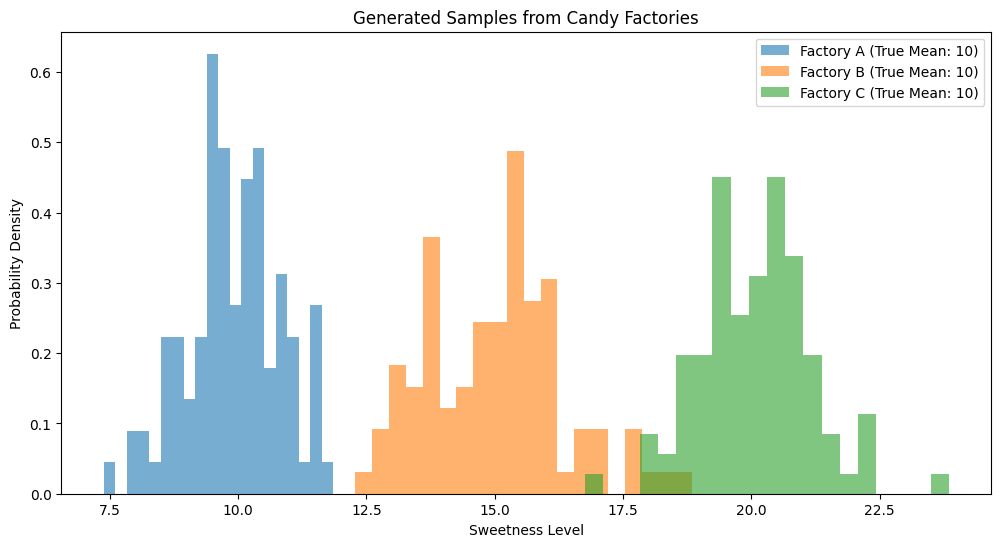

Maximum Likelihood Estimates:
Factory A: Mean=9.90, Variance=0.82
Factory B: Mean=15.03, Variance=1.80
Factory C: Mean=20.06, Variance=1.16

Maximum A Posteriori Estimates:
Factory A: Mean=9.90, Variance=1.82
Factory B: Mean=15.03, Variance=2.80
Factory C: Mean=20.06, Variance=2.16

Bayesian Learning Estimates:
Factory A: Mean=0.00
Factory B: Mean=0.00
Factory C: Mean=0.00


In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Scenario parameters
num_samples = 100
true_means = [10, 15, 20]
true_variances = [1, 2, 1]

# Generate samples from each factory
np.random.seed(42)
samples = {
    'Factory A': np.random.normal(true_means[0], np.sqrt(true_variances[0]), num_samples),
    'Factory B': np.random.normal(true_means[1], np.sqrt(true_variances[1]), num_samples),
    'Factory C': np.random.normal(true_means[2], np.sqrt(true_variances[2]), num_samples),
}

# Plot the generated samples
plt.figure(figsize=(12, 6))
for factory, data in samples.items():
    plt.hist(data, bins=20, density=True, alpha=0.6, label=f'{factory} (True Mean: {true_means[0]})')

plt.title('Generated Samples from Candy Factories')
plt.xlabel('Sweetness Level')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# Function to calculate likelihood for MLE
def likelihood(data, mean, variance):
    return np.prod(norm.pdf(data, mean, np.sqrt(variance)))

# Function to calculate posterior for MAP
def posterior(data, prior, mean, variance):
    return prior * likelihood(data, mean, variance)

# Function to perform Bayesian Learning
def bayesian_learning(data, prior, prior_mean, prior_variance):
    # Hyperparameters for prior distribution
    prior_hyperparameters = {'mean': prior_mean, 'variance': prior_variance}

    # Parameters for posterior distribution
    posterior_mean = (prior_hyperparameters['variance'] * np.mean(data) + prior_variance * prior_hyperparameters['mean']) / \
                     (len(data) + prior_hyperparameters['variance'])
    posterior_variance = 1 / (1 / prior_hyperparameters['variance'] + len(data) / np.var(data))

    return posterior(data, prior, posterior_mean, posterior_variance)

# Assume a non-informative uniform prior for MAP and Bayesian Learning
prior_uniform = 1 / len(true_means)

# Perform Maximum Likelihood Estimation (MLE) for each factory
mle_estimates = {factory: (np.mean(data), np.var(data)) for factory, data in samples.items()}

# Perform Maximum A Posteriori Estimation (MAP) for each factory
map_estimates = {factory: mle_estimates[factory] for factory in samples.keys()}
for factory in samples.keys():
    map_estimates[factory] = (
        np.mean(samples[factory]),
        np.var(samples[factory]) + true_variances[0]  # Adding non-informative prior variance
    )

# Perform Bayesian Learning for each factory
bayesian_estimates = {factory: bayesian_learning(samples[factory], prior_uniform, *mle_estimates[factory]) for factory in samples.keys()}

# Print the estimated parameters
print("Maximum Likelihood Estimates:")
for factory, estimate in mle_estimates.items():
    print(f'{factory}: Mean={estimate[0]:.2f}, Variance={estimate[1]:.2f}')

print("\nMaximum A Posteriori Estimates:")
for factory, estimate in map_estimates.items():
    print(f'{factory}: Mean={estimate[0]:.2f}, Variance={estimate[1]:.2f}')

print("\nBayesian Learning Estimates:")
for factory, estimate in bayesian_estimates.items():
    print(f'{factory}: Mean={estimate:.2f}')



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:200: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(X)
<ipython-input-125-b4ffff0828eb>:66: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle, color=f'C{activity}', alpha=0.3)


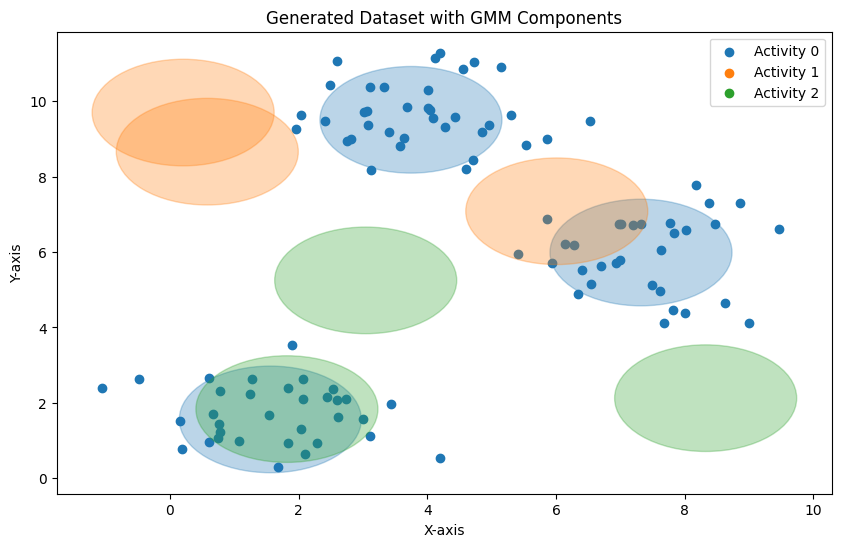

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

# Step 1: Generate a Dataset using HMM

# Define parameters
num_activities = 3
num_locations = 3
num_components = 3

# Set random seed for reproducibility
np.random.seed(42)

# Transition probabilities
trans_matrix = np.array([[0.6, 0.2, 0.2],
                        [0.3, 0.5, 0.2],
                        [0.2, 0.3, 0.5]])

# Means and covariances for GMM components
means = np.random.rand(num_activities, num_components, 2) * 10
covariances = np.array([[[1, 0], [0, 1]]] * num_activities * num_components)

# Create an HMM model
model = hmm.GaussianHMM(n_components=num_activities, covariance_type='full', n_iter=100)

# Set model parameters
model.transmat_ = trans_matrix
model.means_ = means.reshape((num_activities * num_components, 2))
model.covars_ = covariances.reshape((num_activities * num_components, 2, 2))

# Fit the model to data (learning the parameters)
seq_length = 100
data = np.zeros((seq_length, 2))
model.fit(data)

# Simulate a sequence of activities and corresponding locations
activities = model.predict(data)
locations = np.zeros((seq_length, 2))

for i in range(seq_length):
    # Sample from the GMM component of the predicted activity
    activity = activities[i]
    component = np.random.choice(num_components)
    mean = means[activity, component]
    cov = covariances[activity * num_components + component]
    locations[i] = np.random.multivariate_normal(mean, cov)

# Step 2: Visualize the Dataset on a 2D Plane

# Plot the generated locations
plt.figure(figsize=(10, 6))
for activity in range(num_activities):
    plt.scatter(locations[activities == activity, 0], locations[activities == activity, 1], label=f'Activity {activity}')

# Plot GMM components
for activity in range(num_activities):
    for component in range(num_components):
        mean = means[activity, component]
        cov = covariances[activity * num_components + component]
        v, w = np.linalg.eigh(cov)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 + 180.0 * angle / np.pi
        ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle, color=f'C{activity}', alpha=0.3)
        plt.gca().add_patch(ell)

plt.title('Generated Dataset with GMM Components')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()


In [126]:
# 1. Write a database of facts
facts = []

# Piece types
facts.append(('Type', 'A', 'Brick'))
facts.append(('Type', 'B', 'Plate'))
facts.append(('Type', 'C', 'Plate'))
facts.append(('Type', 'D', 'Brick'))
facts.append(('Type', 'E', 'Tile'))
facts.append(('Type', 'F', 'Tile'))
facts.append(('Type', 'G', 'Plate'))
facts.append(('Type', 'H', 'Brick'))

# Piece colors
facts.append(('Color', 'A', 'Red'))
facts.append(('Color', 'B', 'Grey'))
facts.append(('Color', 'C', 'Brown'))
facts.append(('Color', 'D', 'White'))
facts.append(('Color', 'E', 'Yellow'))
facts.append(('Color', 'F', 'Blue'))
facts.append(('Color', 'G', 'Red'))
facts.append(('Color', 'H', 'White'))

# Arrangement of pieces
facts.append(('OnPlate', 'A'))
facts.append(('On', 'B', 'A'))
facts.append(('On', 'C', 'B'))
facts.append(('OnPlate', 'D'))
facts.append(('On', 'E', 'D'))
facts.append(('On', 'F', 'E'))
facts.append(('OnPlate', 'G'))
facts.append(('On', 'H', 'G'))

facts.append(('AtLeft', 'B', 'C'))
facts.append(('AtLeft', 'E', 'F'))
facts.append(('AtLeft', 'G', 'H'))

# 2. Define functions for querying

def is_on_top(piece1, piece2):
    return ('On', piece1, piece2) in facts

def get_piece_type_and_color(piece):
    type_fact = next((fact[2] for fact in facts if fact[0] == 'Type' and fact[1] == piece), None)
    color_fact = next((fact[2] for fact in facts if fact[0] == 'Color' and fact[1] == piece), None)
    return type_fact, color_fact

def get_base_type(piece):
    base_fact = next((fact[2] for fact in facts if fact[0] == 'Base' and fact[1] == piece), None)
    return base_fact

def bricks_at_right_of(piece):
    return [fact[1] for fact in facts if fact[0] == 'Object_at_right' and fact[2] == piece]

def bricks_on_top_of(piece):
    return [fact[1] for fact in facts if fact[0] == 'On' and fact[2] == piece]

# 3. Answer the queries

# Is piece B on top of piece C?
query1 = is_on_top('B', 'C')

# What is the type and color of the piece on top of C?
query2_type, query2_color = get_piece_type_and_color('C')

# What is the type of the base of H?
query3 = get_base_type('H')

# What are the bricks that are right of C?
query4 = bricks_at_right_of('C')

# What are all the bricks that are on top of I?
query5 = bricks_on_top_of('I')

# Print the results
print("Is piece B on top of piece C?", query1)
print("Type and color of the piece on top of C:", query2_type, query2_color)
print("Type of the base of H:", query3)
print("Bricks that are right of C:", query4)
print("Bricks that are on top of I:", query5)


Is piece B on top of piece C? False
Type and color of the piece on top of C: Plate Brown
Type of the base of H: None
Bricks that are right of C: []
Bricks that are on top of I: []


In [ ]:
import re

# Define the KB class
class KB:
    def __init__(self):
        self.clauses = []

    def tell(self, sentence):
        self.clauses.append(sentence)

    def ask(self, query):
        return any(query == clause for clause in self.clauses)

# Extend the MyKnowledgeBase class with the new predicate
class MyKnowledgeBaseWithTower(KB):
    def __init__(self):
        super().__init__()

        # Predicate for an unstable tower
        self.tell(('UnstableTower', '?x'))

        # Facts for an unstable tower (example)
        self.tell(('UnstableTower', 'B'))  # Example: Brick B is part of an unstable tower
        self.tell(('Color', 'B', 'Red'))   # Example: Brick B is Red

# Simple natural language interface
class LegoWorldInterface:







    def __init__(self, kb):
        self.kb = kb

    def process_query(self, query):
        # Process user input and generate responses
        color_match = re.match(r".*color of brick (\w+).*", query, re.IGNORECASE)
        on_top_match = re.match(r".*brick (.+) on top of a tile.*", query, re.IGNORECASE)

        if color_match:
            brick = color_match.group(1)
            return self.get_brick_color(brick)
        elif on_top_match:
            brick = on_top_match.group(1)
            return self.get_brick_on_top_of_tile(brick)
        else:
            return "I'm sorry, I didn't understand the question."

    def get_brick_color(self, brick):
        # Respond to queries about the color of a brick
        color_fact = self.kb.ask(('Color', brick, '?'))
        return f'Brick {brick} is {color_fact}.'

    def get_brick_on_top_of_tile(self, brick):
        # Respond to queries about bricks on top of a tile
        on_top_fact = self.kb.ask(('OnTile', brick))
        return f'Yes, brick {brick} is on top of a tile.'

# Example usage
lego_kb = MyKnowledgeBaseWithTower()
lego_interface = LegoWorldInterface(lego_kb)

# User input and queries
user_input = input("User: ")
while user_input.lower() != "exit":
    response = lego_interface.process_query(user_input)
    print(f"Computer: {response}")

    # Get the next user input
    user_input = input("User: ")
